In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm.notebook import tqdm

In [3]:
query = "SELECT * FROM hop"

with sqlite3.connect('NPPES_Data_Dissemination.sqlite') as db: 
    hop_sqlite = pd.read_sql(query, db)
    
hop_sqlite

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1508085911,1730166125,58,67,23.925,43.923
1,1508167040,1730166125,51,51,28.196,52.876
2,1508863549,1730166125,340,391,18.302,42.422
3,1508867870,1730166125,50,79,12.658,26.402
4,1508011040,1730166224,132,145,8.579,28.053
...,...,...,...,...,...,...
34176933,1417037664,1497939599,36,106,19.330,42.407
34176934,1417194903,1497939599,22,70,16.629,30.598
34176935,1417406372,1497939599,21,65,20.123,37.750
34176936,1417064825,1497940605,75,79,10.418,34.744


In [3]:
facility_query = "SELECT NPI, [ProviderOrganizationName(LegalBusinessName)], ProviderBusinessPracticeLocationAddressPostalCode, HealthcareProviderTaxonomyCode FROM [nppes] WHERE EntityTypeCode = 2 AND ProviderBusinessPracticeLocationAddressCityName = 'NASHVILLE' AND ProviderBusinessPracticeLocationAddressStateName = 'TN' AND HealthcareProviderPrimaryTaxonomySwitch = 'Y' GROUP BY NPI, 'ProviderOrganizationName(LegalBusinessName)', ProviderBusinessPracticeLocationAddressPostalCode, HealthcareProviderTaxonomyCode"
    
facility_sqlite = pd.read_sql(facility_query, db)
    
facility_sqlite

,NPI,ProviderOrganizationName(LegalBusinessName),ProviderBusinessPracticeLocationAddressPostalCode,HealthcareProviderTaxonomyCode
0,1003046509,JARMON D & Q TRANSORT,372071308,343900000X
1,1003085754,DOHNAL CHIROPRACTIC INC.,372116810,111N00000X
2,1003107673,"MEHARRY MEDICAL COLLEGE, SCHOOL OF DENTISTRY",37208,261QD0000X
3,1003118126,"KEISER CHIROPRACTIC NEUROLOGY CENTER, PC",372143530,111NN0400X
4,1003152208,"TRISTAR GYNECOLOGY ONCOLOGY, LLC",372031534,207VX0201X
...,...,...,...,...
2979,1992972087,INTERNAL MEDICINE ASSOCIATES OF SOUTHERN HILLS...,372114880,207R00000X
2980,1992972772,TAXI USA OF TENNESSEE LLC,37210,344600000X
2981,1992978746,"HAL SCHOFIELD MD, PC",372122804,2084P0800X
2982,1992987101,"RENAISSANCE WOMEN'S CENTER, PC",372281511,261QM2500X


In [4]:
provider_query = "SELECT NPI, ProviderFirstName, [ProviderLastName(LegalName)], ProviderNamePrefixText, ProviderNameSuffixText, ProviderCredentialText, HealthcareProviderTaxonomyCode FROM [NPPES] WHERE EntityTypeCode = 1 AND ProviderBusinessPracticeLocationAddressCityName = 'NASHVILLE' AND ProviderBusinessPracticeLocationAddressStateName = 'TN' AND HealthcareProviderPrimaryTaxonomySwitch = 'Y' AND HealthcareProviderTaxonomyCode NOT NULL GROUP BY NPI, NPI, ProviderFirstName, [ProviderLastName(LegalName)], ProviderNamePrefixText, ProviderNameSuffixText, ProviderCredentialText, HealthcareProviderTaxonomyCode"

provider = pd.read_sql(provider_query, db)

provider

,NPI,ProviderFirstName,ProviderLastName(LegalName),ProviderNamePrefixText,ProviderNameSuffixText,ProviderCredentialText,HealthcareProviderTaxonomyCode
0,1003000282,ROSIE,BLAKEMORE,None,None,FNP,363LF0000X
1,1003007923,CLYDE,RAMEY,None,None,None,171M00000X
2,1003009549,RAMUNE,SILEIKYTE,None,None,None,390200000X
3,1003010588,ENGLISH,FLACK,None,None,MD,2080P0202X
4,1003013947,ROBERT,OTTO,DR.,None,M.D.,207X00000X
...,...,...,...,...,...,...,...
19502,1992987085,SUSANNE,HORTON,None,None,CRNA,367500000X
19503,1992987572,KIMBERLY,ANDERSON,None,None,None,2255A2300X
19504,1992987671,MARIAN,MORGAN,None,None,RN,363LF0000X
19505,1992992697,KARA,COLE,None,None,PA,363AS0400X


In [5]:
taxonomy_nucc = pd.read_csv('nucc_taxonomy_230.csv', encoding= 'unicode_escape')

,Code,Grouping,Classification,Specialization,Definition,Notes,Display Name,Section
0,193200000X,Group,Multi-Specialty,NaN,A business group of one or more individual pra...,[7/1/2003: new],Multi-Specialty Group,Individual
1,193400000X,Group,Single Specialty,NaN,A business group of one or more individual pra...,[7/1/2003: new],Single Specialty Group,Individual
2,207K00000X,Allopathic & Osteopathic Physicians,Allergy & Immunology,NaN,An allergist-immunologist is trained in evalua...,"Source: American Board of Medical Specialties,...",Allergy & Immunology Physician,Individual
3,207KA0200X,Allopathic & Osteopathic Physicians,Allergy & Immunology,Allergy,"A physician who specializes in the diagnosis, ...",Source: National Uniform Claim Committee,Allergy Physician,Individual
4,207KI0005X,Allopathic & Osteopathic Physicians,Allergy & Immunology,Clinical & Laboratory Immunology,An allergy and immunology physician who specia...,"Source: National Uniform Claim Committee, 2022...",Clinical & Laboratory Immunology (Allergy & Im...,Individual
...,...,...,...,...,...,...,...,...
868,343800000X,Transportation Services,Secured Medical Transport (VAN),NaN,A public or privately owned transportation ser...,NaN,Secured Medical Transport (VAN),Non-Individual
869,344600000X,Transportation Services,Taxi,NaN,A land commercial vehicle used for the transpo...,NaN,Taxi,Non-Individual
870,347D00000X,Transportation Services,Train,NaN,An organization or business licensed to provid...,NaN,Train,Non-Individual
871,347E00000X,Transportation Services,Transportation Broker,NaN,An organization that provides transportation f...,Source: Section 6083 of the Deficit Reduction ...,Transportation Broker,Non-Individual


In [7]:
provider = provider.merge(taxonomy_nucc, left_on = "HealthcareProviderTaxonomyCode", right_on = "Code")
provider

,NPI,ProviderFirstName,ProviderLastName(LegalName),ProviderNamePrefixText,ProviderNameSuffixText,ProviderCredentialText,HealthcareProviderTaxonomyCode,Code,Grouping,Classification,Specialization,Definition,Notes,Display Name,Section
0,1003000282,ROSIE,BLAKEMORE,None,None,FNP,363LF0000X,363LF0000X,Physician Assistants & Advanced Practice Nursi...,Nurse Practitioner,Family,Definition to come...,NaN,Family Nurse Practitioner,Individual
1,1003111071,GOLD,NWOKOCHAH,None,None,None,363LF0000X,363LF0000X,Physician Assistants & Advanced Practice Nursi...,Nurse Practitioner,Family,Definition to come...,NaN,Family Nurse Practitioner,Individual
2,1003215997,PRINCESS,SHELTON,None,None,FNP-BC,363LF0000X,363LF0000X,Physician Assistants & Advanced Practice Nursi...,Nurse Practitioner,Family,Definition to come...,NaN,Family Nurse Practitioner,Individual
3,1003232927,EMILY,HIATT,MRS.,None,FNP-BC,363LF0000X,363LF0000X,Physician Assistants & Advanced Practice Nursi...,Nurse Practitioner,Family,Definition to come...,NaN,Family Nurse Practitioner,Individual
4,1003245689,JOCELYN,DECKER,None,None,FNP,363LF0000X,363LF0000X,Physician Assistants & Advanced Practice Nursi...,Nurse Practitioner,Family,Definition to come...,NaN,Family Nurse Practitioner,Individual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19502,1972778090,ROBERT,HUNLEY,None,JR.,COTA/L,225XR0403X,225XR0403X,"Respiratory, Developmental, Rehabilitative and...",Occupational Therapist,Driving and Community Mobility,Occupational therapists can optimize and prolo...,Source: The Guide to Occupational Therapy Prac...,Driving and Community Mobility Occupational Th...,Individual
19503,1982651360,JENNIFER,ERICH,None,None,MD,207PH0002X,207PH0002X,Allopathic & Osteopathic Physicians,Emergency Medicine,Hospice and Palliative Medicine,An emergency medicine physician with special k...,Source: American Academy of Hospice and Pallia...,Hospice and Palliative Medicine (Emergency Med...,Individual
19504,1982909370,JESSICA,EASLEY,None,None,None,171WH0202X,171WH0202X,Other Service Providers,Contractor,Home Modifications,Definition to come...,NaN,Home Modifications Contractor,Individual
19505,1992223804,TINA,RAY,None,None,None,364SG0600X,364SG0600X,Physician Assistants & Advanced Practice Nursi...,Clinical Nurse Specialist,Gerontology,Definition to come...,NaN,Gerontology Clinical Nurse Specialist,Individual


In [8]:
provider['Classification'].unique()

array(['Nurse Practitioner', 'Case Manager/Care Coordinator',
       'Student in an Organized Health Care Education/Training Program',
       'Pediatrics', 'Orthopaedic Surgery', 'Pharmacist',
       'Psychiatry & Neurology', 'Internal Medicine',
       'Nurse Anesthetist, Certified Registered', 'Audiologist',
       'Family Medicine', 'Counselor', 'Registered Nurse',
       'Physical Therapist', 'Psychologist', 'Social Worker',
       'Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'Behavior Analyst', 'Speech-Language Pathologist',
       'Genetic Counselor, MS', 'Surgery', 'Anesthesiology', 'Technician',
       'Dentist', 'Occupational Therapist', 'Preventive Medicine',
       'Optometrist', 'Specialist/Technologist', 'Pathology',
       'General Acute Care Hospital', 'Emergency Medicine', 'Hospitalist',
       'Urology', 'Physician Assistant', 'Massage Therapist',
       'Marriage & Family Therapist', 'Case Management',
       'Dietitian, Registered', 'Behavior Technici

In [9]:
facility = facility_sqlite.merge(taxonomy_nucc, left_on = "HealthcareProviderTaxonomyCode", right_on = "Code")
facility = facility[facility['Grouping'] == 'Hospitals']
facility

,NPI,ProviderOrganizationName(LegalBusinessName),ProviderBusinessPracticeLocationAddressPostalCode,HealthcareProviderTaxonomyCode,Code,Grouping,Classification,Specialization,Definition,Notes,Display Name,Section
185,1003211145,MONROE CARELL JR. CHILDREN'S HOSPITAL AT VANDE...,372320005,282NC2000X,282NC2000X,Hospitals,General Acute Care Hospital,Children,Definition to come...,NaN,Children's Hospital,Non-Individual
186,1164609319,VANDERBILT MEDICAL CENTER,372320034,282NC2000X,282NC2000X,Hospitals,General Acute Care Hospital,Children,Definition to come...,NaN,Children's Hospital,Non-Individual
187,1255577466,MONROE CARELL JR VANDERBILT CHILDREN'S HOSPITAL,372320005,282NC2000X,282NC2000X,Hospitals,General Acute Care Hospital,Children,Definition to come...,NaN,Children's Hospital,Non-Individual
188,1326224015,VANDERBILT CHILDRENS HOSPITAL,372320005,282NC2000X,282NC2000X,Hospitals,General Acute Care Hospital,Children,Definition to come...,NaN,Children's Hospital,Non-Individual
189,1609056399,VANDERBILT CHILDREN'S,372320001,282NC2000X,282NC2000X,Hospitals,General Acute Care Hospital,Children,Definition to come...,NaN,Children's Hospital,Non-Individual
...,...,...,...,...,...,...,...,...,...,...,...,...
2881,1700950284,VANDERBILT UNIVERSITY MEDICAL CENTER,372320014,282NC0060X,282NC0060X,Hospitals,General Acute Care Hospital,Critical Access,Definition to come.,[7/1/2003: new],Critical Access Hospital,Non-Individual
2913,1568477990,DEPARTMENT OF VETERANS AFFAIRS NASHVILLE,372122637,286500000X,286500000X,Hospitals,Military Hospital,NaN,A health care facility operated by the Departm...,NaN,Military Hospital,Non-Individual
2935,1699436626,"SAINT THOMAS REHABILITATION HOSPITAL, LLC",372031846,283X00000X,283X00000X,Hospitals,Rehabilitation Hospital,NaN,A hospital or facility that provides health-re...,Source: Joint Commission on Accreditation of H...,Rehabilitation Hospital,Non-Individual
2936,1972749406,VANDERBILT ORTHOPAEDIC INSTITUTE,372320001,283X00000X,283X00000X,Hospitals,Rehabilitation Hospital,NaN,A hospital or facility that provides health-re...,Source: Joint Commission on Accreditation of H...,Rehabilitation Hospital,Non-Individual


In [10]:
provider.to_sql('provider', db, if_exists = 'replace', index = False)

19507

In [11]:
facility.to_sql('facility', db, if_exists = 'replace', index = False)

74

In [12]:
test_query = "SELECT Classification FROM provider"
provider_test = pd.read_sql(test_query, db)

provider_test

,Classification
0,Nurse Practitioner
1,Nurse Practitioner
2,Nurse Practitioner
3,Nurse Practitioner
4,Nurse Practitioner
...,...
19502,Occupational Therapist
19503,Emergency Medicine
19504,Contractor
19505,Clinical Nurse Specialist


In [4]:
specialist_query = "SELECT hop.from_npi, hop.to_npi, hop.patient_count, hop.transaction_count, ProviderFirstName AS First_Name, [ProviderLastName(LegalName)] AS Last_Name, [ProviderOrganizationName(LegalBusinessName)] AS Hospital_Name, provider.Classification FROM provider INNER JOIN hop ON provider.NPI = hop.from_npi LEFT JOIN facility ON hop.to_npi = facility.NPI ORDER BY hop.patient_count DESC;"




specialist_test = pd.read_sql(specialist_query, db)

specialist_test

,from_npi,to_npi,patient_count,transaction_count,First_Name,Last_Name,Hospital_Name,Classification
0,1093753303,1003863580,127792,234741,DEREK,WELCH,None,Pathology
1,1093753303,1124075635,124782,227691,DEREK,WELCH,None,Pathology
2,1093753303,1235186800,111956,203632,DEREK,WELCH,None,Pathology
3,1093753303,1376548271,10982,13287,DEREK,WELCH,None,Pathology
4,1093753303,1861478489,10368,12780,DEREK,WELCH,None,Pathology
...,...,...,...,...,...,...,...,...
63906,1184711293,1104202761,11,132,HELEN,HATFIELD,None,Nurse Practitioner
63907,1346765476,1124443403,11,88,HEATHER,CONLEY,None,Nurse Practitioner
63908,1023253549,1245274778,11,50,RHETT,BRUNER,None,Chiropractor
63909,1215250295,1578596961,11,115,SUNDAY,OGUNDE,None,Internal Medicine


In [5]:
specialist_test['Hospital_Name'].unique()

array([None, 'HCA HEALTH SERVICES OF TENNESSEE, INC.',
       'VANDERBILT UNIVERSITY MEDICAL CENTER',
       'HTI MEMORIAL HOSPITAL CORPORATION', 'SAINT THOMAS WEST HOSPITAL',
       'NASHVILLE GENERAL HOSPITAL', "BAPTIST WOMEN'S HEALTH CENTER LLC",
       'SELECT SPECIALTY HOSPITAL - NASHVILLE LLC', 'SETON CORPORATION',
       'CURAHEALTH NASHVILLE, LLC',
       'STATE OF TENNESSEE STATE F&A PAYROLL'], dtype=object)

In [10]:
specialist_test['Classification'].unique()

array(['Pathology', 'Dermatology', 'Internal Medicine', 'Radiology',
       'Ophthalmology', 'Specialist', 'Nuclear Medicine', 'Surgery',
       'Urology', 'Physician Assistant', 'Anesthesiology',
       'Emergency Medicine', 'Nurse Practitioner', 'Pain Medicine',
       'Clinic/Center', 'Physical Medicine & Rehabilitation',
       'Orthopaedic Surgery', 'Hospitalist', 'Podiatrist',
       'Psychiatry & Neurology', 'Family Medicine',
       'Obstetrics & Gynecology', 'Preventive Medicine', 'Optometrist',
       'Neurological Surgery', 'Nurse Anesthetist, Certified Registered',
       'Otolaryngology',
       'Student in an Organized Health Care Education/Training Program',
       'Physical Therapist', 'Allergy & Immunology', 'Pediatrics',
       'Thoracic Surgery (Cardiothoracic Vascular Surgery)',
       'Plastic Surgery', 'Audiologist', 'Colon & Rectal Surgery',
       'General Practice', 'Audiologist-Hearing Aid Fitter',
       'Transplant Surgery', 'Clinical Nurse Specialist',
    

In [9]:
Nash_NPI = specialist_test[specialist_test.Hospital_Name.isin(['HCA HEALTH SERVICES OF TENNESSEE, INC.',
       'VANDERBILT UNIVERSITY MEDICAL CENTER',
       'HTI MEMORIAL HOSPITAL CORPORATION', 'SAINT THOMAS WEST HOSPITAL',
       'NASHVILLE GENERAL HOSPITAL', "BAPTIST WOMEN'S HEALTH CENTER LLC",
       'SELECT SPECIALTY HOSPITAL - NASHVILLE LLC', 'SETON CORPORATION',
       'CURAHEALTH NASHVILLE, LLC',
       'STATE OF TENNESSEE STATE F&A PAYROLL'])]

Nash_NPI

,from_npi,to_npi,patient_count,transaction_count,First_Name,Last_Name,Hospital_Name,Classification
5,1093753303,1023055126,9196,16819,DEREK,WELCH,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Pathology
11,1417131715,1023055126,5571,9007,JOHN,RIDDICK,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Internal Medicine
24,1316983695,1396882205,3759,4343,ADAM,GUTTENTAG,VANDERBILT UNIVERSITY MEDICAL CENTER,Radiology
26,1740377845,1396882205,3728,4453,DAVID,TABER,VANDERBILT UNIVERSITY MEDICAL CENTER,Radiology
31,1043302466,1396882205,3436,4038,JOHN,BLOCK,VANDERBILT UNIVERSITY MEDICAL CENTER,Radiology
...,...,...,...,...,...,...,...,...
63805,1518054626,1568551455,17,50,SUSAN,KROOP,NASHVILLE GENERAL HOSPITAL,Internal Medicine
63825,1104808641,1396882205,16,57,HARRY,JOHNSON,VANDERBILT UNIVERSITY MEDICAL CENTER,Internal Medicine
63862,1558515437,1396882205,14,56,LINDA,MANNING,VANDERBILT UNIVERSITY MEDICAL CENTER,Psychologist
63888,1255605036,1568551455,12,55,LISA,BOLTON,NASHVILLE GENERAL HOSPITAL,Nurse Practitioner


In [12]:
Nash_NPI[Nash_NPI.Classification.isin(['Orthopaedic Surgery', 'Family Medicine'])]

,from_npi,to_npi,patient_count,transaction_count,First_Name,Last_Name,Hospital_Name,Classification
1029,1922394840,1295780476,740,1860,TRAVIS,GRAVES,HTI MEMORIAL HOSPITAL CORPORATION,Family Medicine
1220,1356433783,1396882205,670,1295,GENE,HANNAH,VANDERBILT UNIVERSITY MEDICAL CENTER,Family Medicine
1904,1619064722,1396882205,525,1205,ANDREW,SHINAR,VANDERBILT UNIVERSITY MEDICAL CENTER,Orthopaedic Surgery
2329,1255488128,1396882205,464,1104,GREGORY,POLKOWSKI,VANDERBILT UNIVERSITY MEDICAL CENTER,Orthopaedic Surgery
2455,1477548154,1720032345,448,1109,GEORGE,HOLMES,"HCA HEALTH SERVICES OF TENNESSEE, INC.",Family Medicine
...,...,...,...,...,...,...,...,...
62318,1528050671,1336119627,33,70,PHILIP,KARPOS,BAPTIST WOMEN'S HEALTH CENTER LLC,Orthopaedic Surgery
63125,1174576599,1396882205,27,69,JULIA,GOMEZ,VANDERBILT UNIVERSITY MEDICAL CENTER,Family Medicine
63232,1225038979,1336119627,26,63,STANLEY,HOPP,BAPTIST WOMEN'S HEALTH CENTER LLC,Orthopaedic Surgery
63471,1598887473,1396882205,24,50,NAGAVIJAYA,ORUGANTI,VANDERBILT UNIVERSITY MEDICAL CENTER,Family Medicine


In [ ]:
sns.barplot(data=gdp_df.groupby(['Continent'])['Country'].nunique().to_frame().reset_index().rename(columns = {'Country' : 'Total_Countries'}), y='Continent', x='Total_Countries', hue='Continent', dodge=False); 

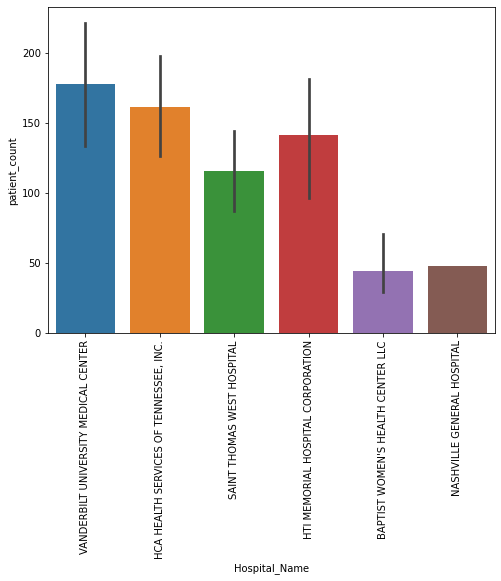

In [19]:
fig, ax = plt.subplots(figsize = (8,6))

sns.barplot(
    data = Nash_NPI[Nash_NPI.Classification.isin(['Orthopaedic Surgery'])],
    x = 'Hospital_Name',
    y = 'patient_count',
    ax = ax
)
plt.xticks(rotation = 90);

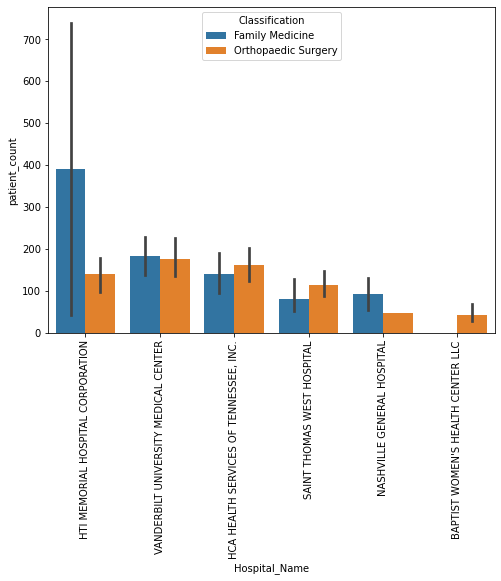

In [23]:
fig, ax = plt.subplots(figsize = (8,6))

sns.barplot(
    data = Nash_NPI[Nash_NPI.Classification.isin(['Family Medicine', 'Orthopaedic Surgery'])],
    x = 'Hospital_Name',
    y = 'patient_count',
    hue = 'Classification',
    ax = ax
)
plt.xticks(rotation = 90);